# Deep Q-Network implementation

This notebook shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

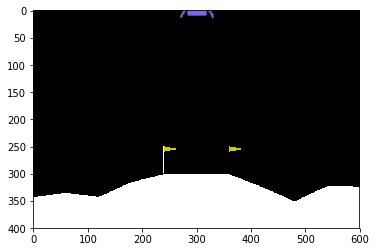

In [2]:
env = gym.make("LunarLander-v2")
env.reset()
img = env.render(mode='rgb_array')
env.close()
plt.imshow(img)

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [4]:
class DQNAgent():
    def __init__(self, state_shape, n_actions,model, epsilon=0):
        """A simple DQN agent"""
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape= state_shape
        self.model = model

    def get_qvalues(self, state):
        """
        state is observation from gym environment
        pytorch needs [batch,s], so add a batch dim in state
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        s = torch.from_numpy(np.expand_dims(state,axis=0)).to(device)
        with torch.no_grad():
            q = self.model.forward(s)
        return np.squeeze(q.cpu().data.numpy(),axis=0)
    
    def get_state_action(self, state):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        action = self.get_qvalues(state).argmax(axis=-1)
        if self.epsilon > 0. and random.random()<eps:
            action = np.random.choice(n_actions)
            
        return action
    
    def get_action(self,state):
        """interface for Agent"""
        return get_state_action(state)

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step

In [5]:
class MLModel(nn.Module):
    def __init__(self,input_size,output_size,n_l1 = 64, n_l2 = 64):
        super(MLModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.layer1 = nn.Linear(input_size,n_l1)
        self.layer2 = nn.Linear(n_l1,n_l2)
        self.output = nn.Linear(n_l2,output_size)
        

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)
    
    @property
    def genome(self):
        return torch.cat((self.layer1.weight.view(-1),self.layer1.bias,\
                                 self.layer2.weight.view(-1),self.layer2.bias,\
                                self.output.weight.view(-1),self.output.bias))
    
    def update_genome(self,genes):
        #calculate index of genes
        w1 = self.layer1.weight.numel()
        b1 = self.layer1.bias.numel() +w1
        w2 = self.layer2.weight.numel() +b1
        b2 = self.layer2.bias.numel() + w2
        w3 = self.output.weight.numel()+b2
        b3 = self.output.bias.numel() +w3
        
        self.layer1.weight.data = genes[:w1].view(self.layer1.weight.shape)
        self.layer1.bias.data = genes[w1:b1].view(self.layer1.bias.shape)
        self.layer2.weight.data = genes[b1:w2].view(self.layer2.weight.shape)
        self.layer2.bias.data = genes[w2:b2].view(self.layer2.bias.shape)
        self.output.weight.data = genes[b2:w3].view(self.output.weight.shape)
        self.output.bias.data = genes[w3:b3].view(self.output.bias.shape)
        

### Construct train & evaluation 



Now let's try out our agent to see if it raises any errors.

In [6]:
import time

def evaluate(env, agent, n_games=1,render=False):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    t_max = env.spec.timestep_limit or 10000
    rewards = []
    
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            action = agent.get_action(s)
            s, r, done, _ = env.step(action)
            if render:
                env.render()
                time.sleep (50.0 / 1000.0);
                
            reward += r
            if done: break
                
        rewards.append(reward)
    
    if render:
        env.close()
    
    return np.mean(rewards)

### Experience replay
#### The interface:
* `exp_replay.push(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [7]:
import random
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward','next_state','done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def head(self):
        return self.memory[-1]

    def __len__(self):
        return len(self.memory)

### Learning with... Q-learning

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{policy_\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [8]:
def td_loss(target_net,policy_net,batch,device,weights=None,GAMMA = 0.99):
    
    s_ = torch.as_tensor(batch.state,dtype=torch.float32).to(device)
    a_ = torch.as_tensor(batch.action,dtype=torch.int64).to(device)
    r_ = torch.as_tensor(batch.reward,dtype=torch.float32).to(device)
    ns_= torch.as_tensor(batch.next_state,dtype=torch.float32).to(device)
    d_= torch.as_tensor(batch.done,dtype=torch.float32).to(device)
    not_d_ = 1 - d_
    
    #predict Q values
    predict_q_ = policy_net(s_).gather(dim=1,index=a_.view(-1,1)).squeeze()
    
    #predict Next QValues with target network
    with torch.no_grad():
        predict_next_q_ = target_net(ns_)
        predict_v_ = torch.max(predict_next_q_,dim=1)[0] * not_d_
        reference_q_ = r_ + GAMMA * predict_v_
    
    #loss = F.mse_loss(predict_q_,reference_q_)
    if weights:
        weights_t = torch.as_tensor(weights,dtype=torch.float32).to(device).detach()
        loss = ((predict_q_ - reference_q_)**2 *weights_t).mean()
    else:
        loss = F.smooth_l1_loss(predict_q_,reference_q_)
    
    return loss

### Main loop

It's time to put everything together and see if it learns anything.

In [8]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim,n_actions = env.observation_space.shape[0],env.action_space.n

In [10]:
policy_net = MLModel(state_dim,n_actions).to(device)
agent = DQNAgent(state_dim, n_actions,policy_net, epsilon=0.5)

In [11]:
evaluate(env, agent, n_games=3,render=True)

-456.6116931812651

In [ ]:
policy_net = MLModel(state_dim,n_actions,n_l1=64,n_l2=128).to(device)
target_net = MLModel(state_dim,n_actions,n_l1=64,n_l2=128).to(device)
target_net.load_state_dict(policy_net.state_dict())
agent = DQNAgent(state_dim, n_actions,policy_net, epsilon=0.5)
test_agent = DQNAgent(state_dim, n_actions,policy_net, epsilon=0.0)
mean_rw_history = []
td_loss_history = []
td_loss_m_history = []
BATCH_SIZE=64
TIME_STEPS=10**5*4
LEARNING_RATE= 0.0005
EPSILON_START = 0.5
EPSILON_END = 0.001
agent.epsilon=EPSILON_START
exp_replay = ReplayMemory(10**5)
optimizer = torch.optim.Adam(policy_net.parameters(),lr= LEARNING_RATE)

# for training
env = gym.make("LunarLander-v2")
# for evaluation
eval_env = gym.make("LunarLander-v2")
s = env.reset()
for i in trange(TIME_STEPS):
    
    # play
    a = agent.get_state_action(s)
    s_next,r,done, _ = env.step(a)
    
    transition = Transition(s,a,r,s_next,done)
    exp_replay.push(transition)
    
    s = s_next
    
    if done:
        s = env.reset()
    
    if len(exp_replay) < BATCH_SIZE:
        continue
    
    # train
    # < sample data from experience replay>
    transitions = exp_replay.sample(BATCH_SIZE-1)
    transitions.append(transition)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for # detailed explanation).
    batch = Transition(*zip(*transitions))
   
    # loss = < compute TD loss >
    loss = td_loss(target_net,policy_net,batch,device)
    
    #< minimize loss by gradient descent >
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    td_loss_history.append(loss.cpu().data.numpy())
    
    count = min(len(td_loss_history),100)
    td_loss_m_history.append(np.mean(td_loss_history[-count:]))
    
    # adjust agent parameters
    agent.epsilon -= (EPSILON_START - EPSILON_END)/TIME_STEPS
    #Load agent weights into target_network
    
    if i % 100 == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if i % 500 == 0:
        
        mean_rw_history.append(evaluate(eval_env, test_agent, n_games=5))
        if mean_rw_history[-1] > 200:
            break
        
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(td_loss_m_history)
        plt.grid()
        plt.show()
        
        

In [23]:
torch.save(target_net.state_dict(), "checkpoint.pt")

In [27]:
policy_net.load_state_dict(torch.load("checkpoint.pt"))

In [ ]:
evaluate(eval_env, test_agent, n_games=1,render=True)

### Prioritized Replay Memory


In [13]:
class SumTree(object):
    """
    This SumTree code is modified version and the original code is from: 
    https://github.com/jaara/AI-blog/blob/master/SumTree.py
    Store the data with its priority in tree and data frameworks.
    """

    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.data_pointer = 0
        self.length= 0
        self.tree = np.zeros(2 * capacity - 1)
        # [--------------parent nodes-------------][-------leaves to record priority-------]
        #             size: capacity - 1                       size: capacity
        self.data = np.zeros(capacity, dtype=object)  # for all transitions
        # [--------------data frame-------------]
        #             size: capacity

    def add(self, p, data):
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data  # update data_frame
        self.update(tree_idx, p)  # update tree_frame

        self.data_pointer += 1
        if self.length< self.capacity:
            self.length +=1
        if self.data_pointer >= self.capacity:  # replace when exceed the capacity
            self.data_pointer = 0

    def update(self, tree_idx, p):
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p
        # then propagate the change through tree
        while tree_idx != 0:    # this method is faster than the recursive loop in the reference code
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for transitions
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_idx = 0
        while True:     # the while loop is faster than the method in the reference code
            cl_idx = 2 * parent_idx + 1         # this leaf's left and right kids
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):        # reach bottom, end search
                leaf_idx = parent_idx
                break
            else:       # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx] or self.tree[cr_idx] == 0.0:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_p(self):
        return self.tree[0]  # the root
    
    @property
    def leaves(self):
        return self.tree[-self.capacity:] # leaves
    
    def __len__(self):
        return self.length


class PriorExpReplay(object):  # stored as ( s, a, r, s_ ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    epsilon = 0.01  # small amount to avoid zero priority
    alpha = 0.6  # [0~1] convert the importance of TD error to priority
    beta = 0.4  # importance-sampling, from initial value increasing to 1
    beta_increment_per_sampling = 0.0001
    abs_err_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def push(self, transition,td_error):
        #max_p = max(np.max(self.tree.leaves),self.abs_err_upper)
        p = np.power(td_error,self.alpha)
        self.tree.add(p, transition)   # set the max p for new p

    def sample(self, n):
        indice = []
        transitions = []
        weights = []
        
        pri_seg = self.tree.total_p / float(n)       # priority segment
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])  # max = 1
        
        #min_prob = np.min(self.tree.leaves[self.tree.leaves.nonzero()]) / self.tree.total_p # for later calculate ISweight
        p_avg = self.tree.total_p/len(self.tree)
        
        for i in range(n):
            a, b = pri_seg * i, pri_seg * (i + 1)
            v = np.random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(v)
            
            indice.append(idx)
            transitions.append(data)
            weights.append((p/p_avg)** (-self.beta))
        return indice, transitions, weights

    def batch_update(self, tree_idx, abs_errors):
        #abs_errors += self.epsilon  # convert to abs and avoid 0
        #clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(abs_errors, self.alpha)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)
    
    def __len__(self):
        return len(self.tree)

In [14]:
def td_error(target_net,policy_net,batch,device,GAMMA = 0.99):
    s_ = torch.as_tensor(batch.state,dtype=torch.float32).to(device)
    a_ = torch.as_tensor(batch.action,dtype=torch.int64).to(device)
    r_ = torch.as_tensor(batch.reward,dtype=torch.float32).to(device)
    ns_= torch.as_tensor(batch.next_state,dtype=torch.float32).to(device)
    d_= torch.as_tensor(batch.done,dtype=torch.float32).to(device)
    not_d_ = 1 - d_
    
    with torch.no_grad():
        #predict Q values
        predict_q_ = policy_net(s_).gather(dim=1,index=a_.view(-1,1)).squeeze()
        #predict Next QValues with target network
        predict_next_q_ = target_net(ns_)
        predict_v_ = torch.max(predict_next_q_,dim=1)[0] * not_d_
        reference_q_ = r_ + GAMMA * predict_v_
    
        #loss = F.mse_loss(predict_q_,reference_q_)
        error = torch.abs(predict_q_- reference_q_)
    
    return error.cpu().numpy().squeeze()

 17%|█▋        | 66147/400000 [17:40<1:23:34, 66.57it/s]

In [ ]:
policy_net = MLModel(state_dim,n_actions,n_l1=64,n_l2=128).to(device)
target_net = MLModel(state_dim,n_actions,n_l1=64,n_l2=128).to(device)
target_net.load_state_dict(policy_net.state_dict())
agent = DQNAgent(state_dim, n_actions,policy_net, epsilon=0.5)
test_agent = DQNAgent(state_dim, n_actions,policy_net, epsilon=0.0)

mean_rw_history = []
td_loss_history = []
td_loss_m_history = []
BATCH_SIZE=64
TIME_STEPS=10**5*4
LEARNING_RATE= 0.0005
EPSILON_START = 0.5
EPSILON_END = 0.001
agent.epsilon=EPSILON_START
exp_replay = PriorExpReplay(10**5)
optimizer = torch.optim.Adam(policy_net.parameters(),lr= LEARNING_RATE)

# for training
env = gym.make("LunarLander-v2")
# for evaluation
eval_env = gym.make("LunarLander-v2")
s = env.reset()
for i in trange(TIME_STEPS):
    
    # play
    a = agent.get_state_action(s)
    s_next,r,done, _ = env.step(a)
    
    transition = Transition(s,a,r,s_next,done)
    s = s_next
    
    if done:
        s = env.reset()
    
    batch = Transition(*zip(*[transition]))
    td_err = td_error(target_net,policy_net,batch,device)
    exp_replay.push(transition,td_err)
    if i < BATCH_SIZE:
        continue
    
    # train
    # < sample data from experience replay>
    indice,transitions,weights = exp_replay.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
   
    # loss = < compute TD loss >
    loss = td_loss(target_net,policy_net,batch,device,weights)
    
    #< minimize loss by gradient descent >
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    td_errs = td_error(target_net,policy_net,batch,device)
    exp_replay.batch_update(indice,td_errs)
    
    td_loss_history.append(loss.cpu().data.numpy())
    
    count = min(len(td_loss_history),100)
    td_loss_m_history.append(np.mean(td_loss_history[-count:]))
    
    # adjust agent parameters
    agent.epsilon -= (EPSILON_START - EPSILON_END)/TIME_STEPS
    
    if i % 10 == 0:
        #Load agent weights into target_network
        target_net.load_state_dict(policy_net.state_dict())
        
    if i % 100 == 0:
        
        mean_rw_history.append(evaluate(eval_env, test_agent, n_games=5))
        
        if mean_rw_history[-1] > 200:
            break
        
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        plt.figure(figsize=[12, 4])        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(td_loss_m_history)
        plt.grid()
        plt.show()
        

### Video

In [32]:
agent.epsilon=0 # Don't forget to reset epsilon back to previous value if you want to go on training

In [36]:
#record sessions
import gym.wrappers
env_monitor = gym.wrappers.Monitor(eval_env,directory="videos",force=True)
sessions = [evaluate(env_monitor, agent, n_games=1,render=True) for _ in range(1)]
env_monitor.close()
eval_env.close()

In [37]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## Bonus I (2+ pts)

Implement and train double q-learning.

This task contains of
* Implementing __double q-learning__ or __dueling q-learning__ or both (see tips below)
* Training a network till convergence
  * Full points will be awarded if your network gets average score of >=10 (see "evaluating results")
  * Higher score = more points as usual
  * If you're running out of time, it's okay to submit a solution that hasn't converged yet and updating it when it converges. _Lateness penalty will not increase for second submission_, so submitting first one in time gets you no penalty.


#### Tips:
* Implementing __double q-learning__ shouldn't be a problem if you've already have target networks in place.
  * You will probably need `tf.argmax` to select best actions
  * Here's an original [article](https://arxiv.org/abs/1509.06461)

* __Dueling__ architecture is also quite straightforward if you have standard DQN.
  * You will need to change network architecture, namely the q-values layer
  * It must now contain two heads: V(s) and A(s,a), both dense layers
  * You should then add them up via elemwise sum layer.
  * Here's an [article](https://arxiv.org/pdf/1511.06581.pdf)

## Bonus II (5+ pts): Prioritized experience replay

In this section, you're invited to implement prioritized experience replay

* You will probably need to provide a custom data structure
* Once pool.update is called, collect the pool.experience_replay.observations, actions, rewards and is_alive and store them in your data structure
* You can now sample such transitions in proportion to the error (see [article](https://arxiv.org/abs/1511.05952)) for training.

It's probably more convenient to explicitly declare inputs for "sample observations", "sample actions" and so on to plug them into q-learning.

Prioritized (and even normal) experience replay should greatly reduce amount of game sessions you need to play in order to achieve good performance. 

While it's effect on runtime is limited for atari, more complicated envs (further in the course) will certainly benefit for it.

Prioritized experience replay only supports off-policy algorithms, so pls enforce `n_steps=1` in your q-learning reference computation (default is 10).

## Neuroevolution Search method

In [12]:
def population_initialization(size,n_input,n_output):
    return [MLModel(n_input,n_output) for _ in range(size)]

In [13]:
def get_fitness_score(model,agent,env):
    agent.model = model
    return evaluate(env, agent, n_games=3)

In [47]:
def breed(parent1,parent2,mutation_rate=0.1):
    gen1 = parent1.genome
    gen2 = parent2.genome
    gen_length= gen1.numel()
    genes_pool = torch.stack((gen1,gen2),dim=1)
    #cross_over
    child_genes = genes_pool.gather(1, index=torch.randint(0,2,size=(gen_length,1),dtype=torch.int64))
    child_genes.squeeze_()
    #mutation
    if mutation_rate>0:
        mutated_num = int(gen_length * mutation_rate)
        mutated_idx = torch.randint(gen_length,(mutated_num,),dtype=torch.int64)
        mutation_vals = torch.rand((mutated_num,))-0.5
        child_genes.index_add_(0,mutated_idx,mutation_vals)
        
        
    child = MLModel(parent2.input_size,parent2.output_size)
    child.update_genome(child_genes)
    
    return child 

In [91]:
def evolve(populations,fitness_scores,agent,env, survive_rate = 0.2,epsilon = 0.001):
    # test fitness
    pop_length= len(populations)
    
    # convert fitness_scores to probablity for survive
    scores= np.array(fitness_scores)
    min_score = np.min(scores,axis=0)
    scores = scores- min_score + epsilon
    probablities = (scores/ np.linalg.norm(scores))**2
    
    #select survivors
    survive_count = int(pop_length * survive_rate)
    survive_idx = np.random.choice(pop_length,size=survive_count,p = probablities)
    survivors = np.array(populations)[survive_idx].tolist()
    
    #breed
    child_count = pop_length - survive_count
    children = []
    
    for _ in range(child_count):
        p1,p2 = np.random.choice(survive_count,size=2)
        parent1 = survivors[p1]
        parent2 = survivors[p2]
        child = breed(parent1,parent2)
        children.append(child)
        
    new_pops = survivors + children
    fitness_scores = [get_fitness_score(model,agent,env) for model in new_pops]
    
    return new_pops,fitness_scores
    
    

In [93]:
#
from collections import deque
POP_SIZE=50
GENERATION_NUM = 1000
print('training...')
# initialize polulation
pops = population_initialization(POP_SIZE,state_dim,n_actions)
agent = DQNAgent(state_dim,n_actions,pops[0],epsilon=0)
evolve_env = gym.make("LunarLander-v2")
evolve_env.seed(0)
score_history1 = deque(maxlen=50)
score_history2 = deque(maxlen=50)
score_history3 = deque(maxlen=50)

fitness_scores = [get_fitness_score(model,agent,env) for model in pops]
best_pop = pops[0]

for i in range(GENERATION_NUM):
    pops, fitness_scores = evolve(pops,fitness_scores,agent,evolve_env)
    score_sort_idx = np.argsort(fitness_scores)

    score_history1.append(fitness_scores[score_sort_idx[-1]])
    score_history2.append(fitness_scores[score_sort_idx[-2]])
    score_history3.append(fitness_scores[score_sort_idx[-3]])
    print('\rEpisode {}  Top 3 Scores: {:.2f}, {:.2f}, {:.2f}'.format(i, \
                    np.mean(score_history1),np.mean(score_history2),np.mean(score_history3)),end="")
    
    if i %100 == 0:
        print('\rEpisode {}  Top 3 Scores: {:.2f}, {:.2f}, {:.2f}'.format(i, \
                    np.mean(score_history1),np.mean(score_history2),np.mean(score_history3)))
    
    if np.mean(score_history1) >= 200:
        print("\nEvolution reaches target species with score:{}".format(fitness_scores[score_sort_idx[-1]]))
        best_pop = pops[score_sort_idx[-1]]
        break

training...
Episode 0  Top 3 Scores: -118.47, -118.60, -119.53
Episode 100  Top 3 Scores: -40.22, -60.17, -69.29
Episode 200  Top 3 Scores: 35.07, 2.21, -11.07926
Episode 228  Top 3 Scores: 80.58, 34.57, 18.40evolution reaches target species with score:-455.0472179583442


In [100]:
agent.model = best_pop
evaluate(evolve_env, agent, n_games=1,render=True)

265.8409383010742

### Policy Gradient Monte Carlo Method

In [10]:
from torch.distributions.categorical import Categorical

class PGAgent():
    def __init__(self,model):
        """A simple PG agent"""
        self.model = model
    
    def get_action(self,state):
        """interface for Agent"""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        s = torch.from_numpy(np.expand_dims(state,axis=0)).to(device)
        with torch.no_grad():
            logits = self.model.forward(s)
            m = Categorical(logits = logits)
            action = m.sample()
            
        return action.cpu().numpy().data[0]

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim,n_actions = env.observation_space.shape[0],env.action_space.n

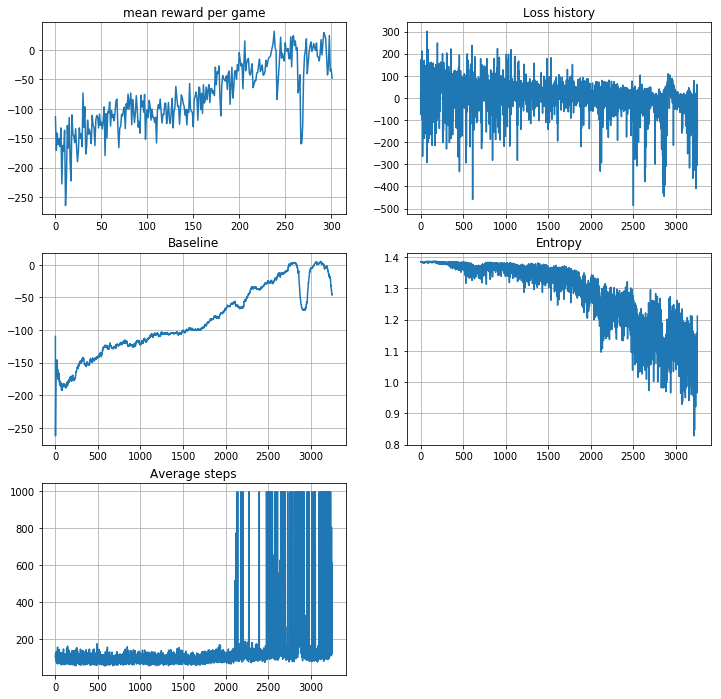









 33%|███▎      | 3253/10000 [16:18<2:14:11,  1.19s/it]







 33%|███▎      | 3254/10000 [16:18<1:38:41,  1.14it/s]







 33%|███▎      | 3255/10000 [16:20<2:13:00,  1.18s/it]







 33%|███▎      | 3256/10000 [16:20<1:37:49,  1.15it/s]







 33%|███▎      | 3257/10000 [16:21<1:14:01,  1.52it/s]







 33%|███▎      | 3258/10000 [16:21<57:59,  1.94it/s]  







 33%|███▎      | 3259/10000 [16:21<57:57,  1.94it/s]







 33%|███▎      | 3260/10000 [16:21<45:01,  2.49it/s]

KeyboardInterrupt: 

In [22]:
from collections import deque
pg_model = MLModel(state_dim,n_actions,n_l1=64,n_l2=128)
agent = PGAgent(pg_model)

EPISODE_NUM = 10000
LEARNING_RATE= 0.0005
BATCH_SIZE = 64

optimizer = torch.optim.Adam(pg_model.parameters(),lr= LEARNING_RATE)
mean_rw_history = []
loss_history = []
entropy_history =[]
baseline_history = []
steps = []
# for training
env = gym.make("LunarLander-v2")
# for evaluation
eval_env = gym.make("LunarLander-v2")

env.seed(0)
eval_env.seed(0)
np.random.seed(0)

t_max = env.spec.timestep_limit or 1000
t_max = 1000


mean_total_rewards = deque(maxlen=100)

for i in trange(EPISODE_NUM):
    
    # play
    
    states = []
    actions = []
    rewards = []
    returns = []
    
    s = env.reset()
    done = False
    
    for step in range(t_max):
        a = agent.get_action(s)
        s_next,r,done, _ = env.step(a)
    
        rewards.append(r)
        states.append(s)
        actions.append(a)

        
        s = s_next
        if done:
            break;
    
    if not done:
        print("episode is not terminated!!!")
        rewards[-1] = -10000.
    
    total_reward = np.sum(rewards)
    mean_total_rewards.append(total_reward)
    mean_baseline = np.mean(mean_total_rewards)
    returns = []

    g = 0.0
    for i,r in enumerate(reversed(rewards)):
        g = r + g
        returns.append(g)

    returns.reverse()
    advantages = np.array(returns) -mean_baseline
    
    
    indice = np.array(range(step))
    np.random.shuffle(indice)
    
    
    while 
    
    if step>BATCH_SIZE:
        idx = np.random.randint(step,size=BATCH_SIZE)
    
    states_t = torch.FloatTensor(np.array(states)[idx]).to(device)
    advantage_t = torch.FloatTensor(np.array(advantages)[idx]).to(device)
    actions_t = torch.LongTensor(np.array(actions)[idx]).to(device)
    logits = pg_model(states_t)
    log_prob = F.log_softmax(logits,dim = 1)
    J = advantage_t * log_prob[range(len(idx)),actions_t]

    # entropy
    prob = F.softmax(logits,dim=1)
    entropy = -(prob * log_prob).sum(dim=1).mean()
    loss = -J.mean() - entropy * 0.01

    loss_history.append(loss.cpu().data)
    baseline_history.append(mean_baseline)
    entropy_history.append(entropy.cpu().data.numpy())
    steps.append(step)

    #< minimize loss by gradient descent >
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
        
    if i % 10 == 0:
        mean_rw_history.append(evaluate(eval_env, agent, n_games=5))
        
        if mean_rw_history[-1] > 200:
            print("Reach the target score 200 of 5 games")
            break
        
        clear_output(True)
        plt.figure(figsize=[12, 12])        
        plt.subplot(3,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        plt.subplot(3,2,2)
        plt.title("Loss history")
        plt.plot(loss_history)
        plt.grid()
        
        plt.subplot(3,2,3)
        plt.title("Baseline")
        plt.plot(baseline_history)
        plt.grid()
        
        plt.subplot(3,2,4)
        plt.title("Entropy")
        plt.plot(entropy_history)
        plt.grid()
        
        plt.subplot(3,2,5)
        plt.title("Average steps")
        plt.plot(steps)
        plt.grid()
        plt.show()
        
        
        

In [25]:
evaluate(eval_env, agent, n_games=1,render=True)

14.078602276524649

In [102]:
states = []
actions = []
rewards = []
returns = []

s = env.reset()
done = False

for step in range(400):
    a = agent.get_action(s)
    s_next,r,done, _ = env.step(a)

    rewards.append(r)
    states.append(s)
    actions.append(a)


    s = s_next
    if done:
        break;

if not done:
    print("episode is not terminated!!!")
    
    rewards[-1] = -10000.

print(step)
total_reward = np.sum(rewards)
mean_total_rewards.append(total_reward)
mean_baseline = np.mean(mean_total_rewards)
returns = []

g = 0.0
for i,r in enumerate(reversed(rewards)):
    g = r + g
    returns.append(g)

episode is not terminated!!!
399


In [103]:
total_reward

-9977.788591092269